1.У вас, с прошлого урока, имеются реализации расчёта среднеквадратичной ошибки и её градиента для линейнй регрессии с коэффициентами при факторах(w) и свободным коэффициентам.
```python
class linear_regression:
    def _mserror(self, X, y_real):
        #рассчёт среднеквадратичной ошибки
        y = X.dot(self.w.T)+self.w0
        return np.sum((y - y_real)**2) / y_real.shape[0]
    def _mserror_grad(self, X, y_real):
        #рассчёт градиента ошибки.
        #2*delta.T.dot(X)/y_real.shape[0] - градиент по коэффициентам при факторах
        #np.sum(2*delta)/y_real.shape[0] - производная(градиент) при нулевом коэффициенте
        delta=(X.dot(self.w.T)+self.w0-y_real)
        return 2*delta.T.dot(X)/y_real.shape[0], np.sum(2*delta)/y_real.shape[0]
```
В этом задании вы должны модифицировать реализацию рассчёта среднеквадратичной ошибки и рассчёта её производной, так, чтобы с к среднеквадратичной ошибке добавлялась l2 регулярязационная поправка: $ +c*\sum \limits _{j}  w_{j}^2 $ а к градиенту- ссответствующее выражение для градиента регулярязационной поправки.

In [1]:
import numpy as np
class linear_regression_with_L2:
    def __init__(self, eta = 0.9, max_iter = 1e4, min_weight_dist = 1e-8):
        self.eta = eta
        self.max_iter = max_iter
        self.min_weight_dist = min_weight_dist
    def _mserror(self, X, y_real):
        #рассчёт среднеквадратичной ошибки
        y = X.dot(self.w.T)+self.w0+10*(np.sum(np.dot(self.w,self.w.T))+self.w0)
        return np.sum((y - y_real)**2) / y_real.shape[0]
    def _mserror_grad(self, X, y_real):
        #рассчёт градиента ошибки.
        #2*delta.T.dot(X)/y_real.shape[0] - градиент по коэффициентам при факторах
        #np.sum(2*delta)/y_real.shape[0] - производная(градиент) при нулевом коэффициенте
        delta=(X.dot(self.w.T)+self.w0+10*(np.sum(np.dot(self.w,self.w.T))+self.w0)-y_real)
        return 2*delta.T.dot(X)/y_real.shape[0], np.sum(2*delta)/y_real.shape[0]
    def _optimize(self, X, Y):
        #оптимизация коэффициентов
        iter_num = 0
        weight_dist = np.inf
        self.w = np.zeros((1, X.shape[1]))
        self.w0=0
        while weight_dist > self.min_weight_dist and iter_num < self.max_iter:
            gr_w, gr_w0=self._mserror_grad(X, Y)
            if iter_num==0:
                #Чтобы eta адаптировалась к порядку градиента, делим на l2 норму градиента в нуле
                eta=self.eta/np.sqrt(np.linalg.norm(gr_w)**2+(gr_w0)**2)
            new_w = self.w - eta * gr_w
            new_w0= self.w0 - eta * gr_w0
            weight_dist = np.sqrt(np.linalg.norm(new_w - self.w)**2+(new_w0 - self.w0)**2)
            iter_num += 1
            self.w = new_w
            self.w0 = new_w0
    def fit(self, X, Y):
        if Y.ndim==1:
            Y=Y[:, np.newaxis]
        self._optimize(X, Y)
    def predict(self, X):
        return (X.dot(self.w.T)+self.w0).flatten()
    def test(self, X, Y):
        if Y.ndim==1:
            Y=Y[:, np.newaxis]
        return self._mserror(X, Y)

2.На основе этих функций создайте свою регуляризированную полиномиальную регрессию и опробуйте на одном из примеров построения полиномиальной модели из этого урока. <br>
<i><b>Пояснение:</b>Для этого Вам достаточно создать класс, который наследуется от класса polynomial_regression из данного урока, и переопределить в нём методы mserror, mserror_grad(под переопределением подразумевается создание на новом классе методов с таким же названием). </i>

In [2]:
import matplotlib
#import numpy as np
import matplotlib.pyplot as plt
from linear_regression import linear_regression
from sklearn.linear_model import LinearRegression as sklearn_LR
%matplotlib inline

In [3]:
def f(x):
    return 0.6 - 13.2 * x - 5.3 * x ** 2 - 4.17 * x ** 3
dots = np.linspace(-10, 10, 100)

In [4]:
def f(x):
    return 0.6 - 13.2 * x - 5.3 * x ** 2 - 4.17 * x ** 3
np.random.seed(16)
x_data = np.random.uniform(-10, 10, 10)
f_data = [f(i) for i in x_data] + np.random.uniform(-1000, 1000, 10)

In [5]:
class polynomial_regression(linear_regression):
    def __init__(self, max_power, *args, **kwargs):
        self.max_power=max_power
        super().__init__(*args, **kwargs)
    @staticmethod
    def generate_features(x, max_power):
        x=x[:, np.newaxis]
        return np.concatenate([x**i for i in range(1, max_power+1)], axis=1)
    def fit(self, x, y):
        super().fit(self.generate_features(x, self.max_power), y)
    def predict(self, x):
        return super().predict(self.generate_features(x, self.max_power)).flatten()
    def test(self, x, y):
        return super().test(self.generate_features(x, self.max_power), y)
    
class polynomial_regression_sklearn(sklearn_LR):
    def __init__(self, max_power, *args, **kwargs):
        self.max_power=max_power
        super().__init__(*args, **kwargs)
    generate_features=staticmethod(polynomial_regression.generate_features)
    def fit(self, x, y):
        super().fit(self.generate_features(x, self.max_power), y)
    def predict(self, x):
        return super().predict(self.generate_features(x, self.max_power))
    def test(self, x, y):
        return np.sum((self.predict(x) - y)**2) / y.shape[0]

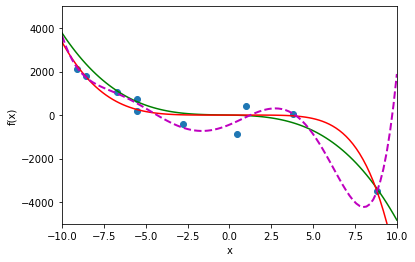

In [6]:
#Актуальные данные
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)
plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)

#Наша модель
model1 = polynomial_regression(6, 0.0005, max_iter = 1e5)
model1.fit(x_data, f_data)
plt.plot(dots, model1.predict(dots), color='r')

#Sklearn
model2 = polynomial_regression_sklearn(6)
model2.fit(x_data, f_data)
plt.plot(dots, model2.predict(dots), 'm--', linewidth=2)

In [7]:
class polynomial_regression_with_L2(polynomial_regression):
    def _mserror(self, X, y_real):
        y = X.dot(self.w.T)+self.w0+10*(np.sum(np.dot(self.w,self.w.T))+self.w0) # 10*(np.sum(np.dot(self.w,self.w.T))+self.w0 - L2 резуляризация
        return np.sum((y - y_real)**2) / y_real.shape[0]
    def _mserror_grad(self, X, y_real):
        delta=(X.dot(self.w.T)+self.w0+10*(np.sum(np.dot(self.w,self.w.T))+self.w0)-y_real)
        return 2*delta.T.dot(X)/y_real.shape[0], np.sum(2*delta)/y_real.shape[0]
    

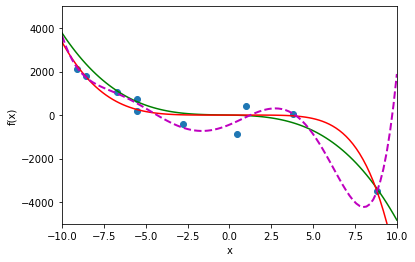

In [8]:
#Актуальные данные
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)
plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)

#Наша модель
model3 = polynomial_regression_with_L2(6, 0.0005, max_iter = 1e5)
model3.fit(x_data, f_data)
plt.plot(dots, model1.predict(dots), color='r')

#Sklearn
model2 = polynomial_regression_sklearn(6)
model2.fit(x_data, f_data)
plt.plot(dots, model2.predict(dots), 'm--', linewidth=2)

In [9]:
print('Коэффициенты при факторах(наша модель):', model1.w)
print('Коэффициенты при факторах(наша модель+L2):', model3.w)
print('Коэффициенты при факторах(sklearn):', model2.coef_)
print('Нулевые коэффициенты(интерцепты):',model1.w0,model3.w0, model2.intercept_)

Коэффициенты при факторах(наша модель): [[-0.00026019  0.00221125 -0.00941793  0.06163923 -0.05145382 -0.00241749]]
Коэффициенты при факторах(наша модель+L2): [[-0.00026015  0.00221094 -0.00941703  0.06163246 -0.05145374 -0.00241754]]
Коэффициенты при факторах(sklearn): [ 3.18714291e+02  5.91424507e+01 -2.19724981e+01 -2.73548014e+00
  1.79059852e-01  2.46511203e-02]
Нулевые коэффициенты(интерцепты): 6.566477934318192e-06 6.544936786472908e-06 -441.36648885405566


Никак не пойму почему коэфициенты в моделе с регуляризацией поменялись столь незначительно

3*. (по желанию). Оцените оцените предсказательную способность реализованного метода с использование 5-ти ступенчатой кросс-валидации, показанной в примере выше. 

In [10]:
#Посчитаем р-квадрат
def r_square(y, y_real):
    ss_total=np.sum((y_real-np.mean(y_real))**2)
    ss_res=np.sum((y_real-y)**2)
    return 1-ss_res/ss_total

In [11]:
indexes=np.arange(len(f_data))%5
y_actual=[]
y_predicted=[]

for i in range(5):
    y_actual.append(f_data[indexes==i])
    mod=polynomial_regression_with_L2(3, 0.0005, max_iter = 1e5) # для полинома 3й степени
    mod.fit(x_data[indexes!=i], f_data[indexes!=i])
    y_predicted.append(mod.predict(x_data[indexes==i]))
    
y_actual=np.concatenate(y_actual)
y_predicted=np.concatenate(y_predicted)
print(r_square(y_predicted, y_actual))

0.7189504728685427


In [12]:
indexes=np.arange(len(f_data))%5
y_actual=[]
y_predicted=[]

for i in range(5):
    y_actual.append(f_data[indexes==i])
    mod=polynomial_regression_with_L2(6, 0.0005, max_iter = 1e5) # для полинома 6й степени
    mod.fit(x_data[indexes!=i], f_data[indexes!=i])
    y_predicted.append(mod.predict(x_data[indexes==i]))
    
y_actual=np.concatenate(y_actual)
y_predicted=np.concatenate(y_predicted)
print(r_square(y_predicted, y_actual))

0.15825981332050332


In [13]:
indexes=np.arange(len(f_data))%3 # 3х ступенчатая кросс валидация
y_actual=[]
y_predicted=[]

for i in range(5):
    y_actual.append(f_data[indexes==i])
    mod=polynomial_regression_with_L2(3, 0.0005, max_iter = 1e5) # для полинома 3й степени
    mod.fit(x_data[indexes!=i], f_data[indexes!=i])
    y_predicted.append(mod.predict(x_data[indexes==i]))
    
y_actual=np.concatenate(y_actual)
y_predicted=np.concatenate(y_predicted)
print(r_square(y_predicted, y_actual))

0.8000295272215036
